In [7]:
# import the necessary packages
from skimage.segmentation import clear_border
# import pytesseract
import numpy as np
import imutils
import cv2

class PyImageSearchANPR:
    def __init__(self, minAR=4, maxAR=5, debug=False):
        # store the minimum and maximum rectangular aspect ratio
        # values along with whether or not we are in debug mode
        self.minAR = minAR
        self.maxAR = maxAR
        self.debug = debug

    def debug_imshow(self, title, image, waitKey=False):
        # check to see if we are in debug mode, and if so, show the
        # image with the supplied title
        if self.debug:
            cv2.imshow(title, image)
            # check to see if we should wait for a keypress
            if waitKey:
                cv2.waitKey(0)

    def locate_license_plate_candidates(self, gray, keep=5):
        # perform a blackhat morphological operation that will allow
        # us to reveal dark regions (i.e., text) on light backgrounds
        # (i.e., the license plate itself)
        rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
        self.debug_imshow("Blackhat", blackhat)
        # next, find regions in the image that are light
        squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
        light = cv2.threshold(light, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        self.debug_imshow("Light Regions", light)
        # compute the Scharr gradient representation of the blackhat
        # image in the x-direction and then scale the result back to
        # the range [0, 255]
        gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
            dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
        gradX = gradX.astype("uint8")
        self.debug_imshow("Scharr", gradX)
        # blur the gradient representation, applying a closing
        # operation, and threshold the image using Otsu's method
        gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
        thresh = cv2.threshold(gradX, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        self.debug_imshow("Grad Thresh", thresh)
        # perform a series of erosions and dilations to clean up the
        # thresholded image
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        self.debug_imshow("Grad Erode/Dilate", thresh)
        # take the bitwise AND between the threshold result and the
        # light regions of the image
        thresh = cv2.bitwise_and(thresh, thresh, mask=light)
        thresh = cv2.dilate(thresh, None, iterations=2)
        thresh = cv2.erode(thresh, None, iterations=1)
        self.debug_imshow("Final", thresh, waitKey=True)
        # find contours in the thresholded image and sort them by
        # their size in descending order, keeping only the largest
        # ones
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]
        # return the list of contours
        return cnts

    def locate_license_plate(self, gray, candidates,
        clearBorder=False):
        # initialize the license plate contour and ROI
        lpCnt = None
        roi = None
        # loop over the license plate candidate contours
        for c in candidates:
            # compute the bounding box of the contour and then use
            # the bounding box to derive the aspect ratio
            (x, y, w, h) = cv2.boundingRect(c)
            ar = w / float(h)
            # check to see if the aspect ratio is rectangular
            if ar >= self.minAR and ar <= self.maxAR:
                # store the license plate contour and extract the
                # license plate from the grayscale image and then
                # threshold it
                lpCnt = c
                licensePlate = gray[y:y + h, x:x + w]
                roi = cv2.threshold(licensePlate, 0, 255,
                    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                # check to see if we should clear any foreground
                # pixels touching the border of the image
                # (which typically, not but always, indicates noise)
                if clearBorder:
                    roi = clear_border(roi)
                # display any debugging information and then break
                # from the loop early since we have found the license
                # plate region
                self.debug_imshow("License Plate", licensePlate)
                self.debug_imshow("ROI", roi, waitKey=True)
                break
        # return a 2-tuple of the license plate ROI and the contour
        # associated with it
        return (roi, lpCnt)

    def build_tesseract_options(self, psm=7):
        # tell Tesseract to only OCR alphanumeric characters
        alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        options = "-c tessedit_char_whitelist={}".format(alphanumeric)
        # set the PSM mode
        options += " --psm {}".format(psm)
        # return the built options string
        return options
    def find_and_ocr(self, image, psm=7, clearBorder=False):
        # initialize the license plate text
        lpText = None
        # convert the input image to grayscale, locate all candidate
        # license plate regions in the image, and then process the
        # candidates, leaving us with the *actual* license plate
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        candidates = self.locate_license_plate_candidates(gray)
        (lp, lpCnt) = self.locate_license_plate(gray, candidates,
            clearBorder=clearBorder)
        # only OCR the license plate if the license plate ROI is not
        # empty
        if lp is not None:
            # OCR the license plate
            options = self.build_tesseract_options(psm=psm)
            lpText = pytesseract.image_to_string(lp, config=options)
            self.debug_imshow("License Plate", lp)
        # return a 2-tuple of the OCR'd license plate text along with
        # the contour associated with the license plate region
        return (lpText, lpCnt)

In [8]:
extr = PyImageSearchANPR()

In [ ]:
extr

In [10]:
# from pyimagesearch.anpr import PyImageSearchANPR
from imutils import paths
import argparse
import imutils
import cv2

In [11]:
def cleanup_text(text):
    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [13]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,help="path to input directory of images")
# ap.add_argument("-c", "--clear-border", type=int, default=-1,help="whether or to clear border pixels before OCR'ing")
# ap.add_argument("-p", "--psm", type=int, default=7,help="default PSM mode for OCR'ing license plates")
# ap.add_argument("-d", "--debug", type=int, default=-1,help="whether or not to show additional visualizations")
# args = vars(ap.parse_args())

In [ ]:
# # loop over all image paths in the input directory
# for imagePath in imagePaths:
# 	# load the input image from disk and resize it
# 	image = cv2.imread(imagePath)
# 	image = imutils.resize(image, width=600)
# 	# apply automatic license plate recognition
# 	(lpText, lpCnt) = anpr.find_and_ocr(image, psm=args["psm"],
# 		clearBorder=args["clear_border"] > 0)
# 	# only continue if the license plate was successfully OCR'd
# 	if lpText is not None and lpCnt is not None:
# 		# fit a rotated bounding box to the license plate contour and
# 		# draw the bounding box on the license plate
# 		box = cv2.boxPoints(cv2.minAreaRect(lpCnt))
# 		box = box.astype("int")
# 		cv2.drawContours(image, [box], -1, (0, 255, 0), 2)
# 		# compute a normal (unrotated) bounding box for the license
# 		# plate and then draw the OCR'd license plate text on the
# 		# image
# 		(x, y, w, h) = cv2.boundingRect(lpCnt)
# 		cv2.putText(image, cleanup_text(lpText), (x, y - 15),
# 			cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
# 		# show the output ANPR image
# 		print("[INFO] {}".format(lpText))
# 		cv2.imshow("Output ANPR", image)
# 		cv2.waitKey(0)

In [105]:
img_path = "data/train/9.jpg"
img_path = "data/train/16.jpg"
img_path = "data/train/20.jpg"
# img_path = "data/train/29.jpg"
# img_path = "data/train/36.jpg"
img_path = "data/train/38.jpg"
img_path = "data/train/40.jpg"
img_path = "data/train/45.jpg"
img_path = "data/train/51.jpg"

image = cv2.imread(img_path)
image = imutils.resize(image, width=600)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
candidates = extr.locate_license_plate_candidates(gray)
(lp, lpCnt) = extr.locate_license_plate(gray, candidates,clearBorder=False)
print(lp, lpCnt)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [[[298 207]]

 [[298 232]]

 [[299 233]]

 [[299 234]]

 [[302 234]]

 [[302 232]]

 [[303 231]]

 [[306 231]]

 [[306 230]]

 [[307 229]]

 [[314 229]]

 [[315 228]]

 [[339 228]]

 [[340 229]]

 [[340 233]]

 [[342 233]]

 [[342 232]]

 [[343 231]]

 [[345 231]]

 [[346 232]]

 [[346 233]]

 [[352 233]]

 [[353 232]]

 [[365 232]]

 [[365 231]]

 [[366 230]]

 [[371 230]]

 [[372 231]]

 [[372 233]]

 [[376 233]]

 [[377 232]]

 [[378 232]]

 [[378 230]]

 [[379 229]]

 [[386 229]]

 [[386 227]]

 [[387 226]]

 [[404 226]]

 [[406 228]]

 [[406 229]]

 [[412 229]]

 [[412 208]]

 [[411 207]]

 [[405 207]]

 [[404 208]]

 [[381 208]]

 [[381 211]]

 [[379 213]]

 [[358 213]]

 [[355 210]]

 [[323 210]]

 [[321 212]]

 [[321 213]]

 [[320 214]]

 [[306 214]]

 [[305 213]]

 [[305 208]]

 [[304 207]]]


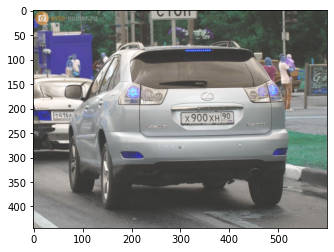

In [106]:
plt.imshow(image)

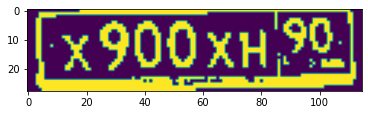

In [107]:
plt.imshow(lp)

In [31]:
lpCnt

In [25]:
import matplotlib.pyplot as plt


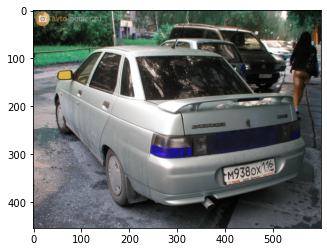

In [29]:
# from matplotlib 
plt.imshow(image)